# POMDP - Tiger Problem

## Problem statement

A tiger is put with equal probability behind one of two doors, while treasure is put behind the other one. You are standing in front of the two closed doors and need to decide which one to open. If you open the door with the tiger, you will get hurt (negative reward). But if you open the door with treasure, you receive a positive reward. Instead of opening a door right away, you also have the option to wait and listen for tiger noises. But listening is neither free nor entirely accurate. You might hear the tiger behind the left door while it is actually behind the right door and vice versa.

![tiger_problem](imgs/tiger_problem.png)

In today's lab, we will consider the following settings:
 - we start with an initial belief that the tiger is placed with equal probability behind each door. This means that our initial belief is a vector \[0.5, 0.5\]
 - the environment allows us to apply a finite number of actions
 - after applying left/right action, the tiger is placed again randomly behind one door, and the episodes continue till we reach the maximum number of steps allowed.
 
Notice that the first two bullets will simplify the problem since the number of belief states that can be reached is finite. It is a well understood fact that most POMDP problems, even given arbitrary action and observation sequences of infinite length, are unlikely to reach most of the points in the belief simplex. Thus it seems unnecessary to plan equally for all beliefs, as exact algorithms do, and preferable to concentrate planning on most probable beliefs.

This allows us to use the "Point-based value iteration" (PBVI) algorithm. PBVI approximates an exact value iteration solution by selecting a small set of representative belief points and then tracking the value and its derivative for those points only. The reader is referred to the paper [here](http://www.cs.cmu.edu/~ggordon/jpineau-ggordon-thrun.ijcai03.pdf).


###  Implementation details

#### Transition Probabilities

| Prob. (LISTEN) | Tiger: left | Tiger: right |      | Prob. (LEFT)   | Tiger: left | Tiger: right |
|----------------|-------------|--------------|      |----------------|-------------|--------------|
| Tiger: left    |    1.0      |    0.0       |      | Tiger: left    |    0.5      |    0.5       |
| Tiger: right   |    0.0      |    1.0       |      | Tiger: right   |    0.5      |    0.5       |


| Prob. (Right)  | Tiger: left | Tiger: right |
|----------------|-------------|--------------|
| Tiger: left    |    0.5      |    0.5       |
| Tiger: right   |    0.5      |    0.5       |

We represented the transition probablility matrices as a 3D tensor, T, with the axis action(a), state(s), state(s').

#### Observation Probabililites

| Prob. (LISTEN) | O: TL | O: TR |      | Prob. (LEFT)   | O: TL | O: TR |
|----------------|-------|-------|      |----------------|-------|-------|
| Tiger: left    |  0.85 |  0.15 |      | Tiger: left    |  0.5  |  0.5  |
| Tiger: right   |  0.15 |  0.85 |      | Tiger: right   |  0.5  |  0.5  |


| Prob. (Right)  | O: TL | O: TR |
|----------------|-------|-------|
| Tiger: left    |  0.5  | 0.5   |
| Tiger: right   |  0.5  | 0.5   |

We represented the observation probablility matrices as a 3D tensor, O, with the axis action(a), state(s), observation(o).


#### Immediate Rewards

| Reward (LISTEN) |       |     | Reward (LEFT) |       |       | Reward (RIGHT) |       |
|-----------------|-------|     |---------------|-------|       |----------------|-------|
| Tiger: left     | -1    |     | Tiger: left   | -100  |       | Tiger: left    |  +10  |
| Tiger: right    | -1    |     | Tiger: right  | +10   |       | Tiger: right   |  -100 |

We represented the reward matrices as a 2D tensor, R, with the axis action(a), state(s).


#### Observation

Current implementation does not use vector operations. Fell free to replace for-loops by vector operation.
Please referre to the [paper](http://www.cs.cmu.edu/~ggordon/jpineau-ggordon-thrun.ijcai03.pdf) for notations.

## Here we go ...

In [1]:
import numpy as np
from typing import List
from pprint import pprint
from itertools import count

from env import *
from util import *

### Belief update

![belief_update](imgs/belief_update.png)



In [2]:
def update_belief(b: np.ndarray, a: Actions, o: Obs, env: TigerEnv) -> np.ndarray:
    """
    Computes the next belief state from the current belief state, applied action
    and received observation
    
    Parameters
    ----------
    b
        Current belief state
    a
        Applied action
    o
        Observation received
    env
        Tiger Environment
    
    Returns
    -------
    Next belief state.
    """
    
    # extract transition probability matrix
    # adn observation probability matrix
    T, O = env.T, env.O
    
    # get states, actions & observations
    states, actions, obs = env.states, env.actions, env.obs
    
    # compute the next belief state
    b_prime = np.zeros_like(b)
    
    for s_prime in states:
        _sum = 0
        for s in states:
            _sum += T[a][s, s_prime] * b[s]
        
        b_prime[s_prime] = O[a][s_prime, o] * _sum
    
    # normalize
    b_prime /= b_prime.sum()
    return b_prime

### Duplicate belief states

Most of the states will result in duplicates. It is important to remove the duplicates in the generation process. This can be implemented by computing the $L_p$ distance between two belief states. You are free to choose any norm you like (e.g. $L_1$, $L_2$, etc.)

In [3]:
def check_duplicate(b: np.ndarray, buff: List[np.ndarray], eps: float = 1e-8) -> bool:
    """
    Checks whether the belief is already in the buffer
    
    Parameters
    ----------
    b
        belief to check if it already exists
    buff
        buffer of beliefs to check against
    eps
        distance threshold
    """
    dist = np.array([np.linalg.norm(b - x) for x in buff])
    return any(dist < eps)

### Beliefs generation process

In [4]:
def get_next_beliefs(b: np.ndarray, env:TigerEnv) -> List[np.ndarray]:
    """
    Generates a list of possible beliefs that can result
    form the current belief passed as argument
    
    Parameters
    ----------
    b
        current belief
    env
        environment
    """
    # get the list of possible actions
    acts, obs = env.actions, env.obs
    buff = []
    
    # go through all the actions
    for a in acts:
        
        # go through all the observations
        for o in obs:
            # update current belief according to the
            # current action and observation using 
            # the update_belief function previously implemented
            b_prime = update_belief(b, a, o, env)
            
            # add the new belief to the buffer only
            # if it is not a duplicate
            if not check_duplicate(b_prime, buff):
                buff.append(b_prime)
    
    return buff

In [5]:
def generate_all_beliefs(b_init: np.ndarray, env: TigerEnv) -> List[List[np.ndarray]]:
    """
    Generate all the possible belief that can result
    in the maximum steps allowed
    
    Parameters
    ----------
    b_init
        initial belief (we're going to use the [0.5, 0.5] for this lab).
    env
        environment
    
    Returns
    -------
    List of lists of belief, meaning that for each step
    we will have a list of belief.
    E.g.
    [
        [b_init],            ---> initial belief (level 1)
        [b00, b01, b02, ...] ---> those result from the initial belief (level 2)
        [b10, b11, b12, ...] ---> those result form the beliefs from the second level (level 3)
        ....
    ]
    """
    
    # extract the maximum number of steps allowe
    # by the environment
    max_num_steps = env.max_num_steps
    
    # initialize storing buffer by adding the 
    # list containing the initial belief
    buff = [[b_init]]
    
    # for  the maximum steps allowed
    for step in range(1, max_num_steps):
        # buffer for the next level of beliefs
        next_buff = []
        
        # go through all beliefs from the previous level
        # and generate new ones
        for b in buff[step - 1]:
            # generate all the belief that can result for
            # belief b (apply get_next_belief previously implemented)
            tmp_buff = get_next_beliefs(b, env)
            
            # we have to check if the new beliefs
            # don't exist already in the next level buffer
            # so we don't add duplicates
            for b_prime in tmp_buff:
                if not check_duplicate(b_prime, next_buff):
                    next_buff.append(b_prime)
            
        # add the new level of beliefs
        buff.append(next_buff)
    
    return buff

### Point-based value backup (1)

![pbvb1](imgs/pbvb1.png)

In [6]:
def get_gamma_a_star(a: Actions, env: TigerEnv) -> np.ndarray:
    """
    Parameters
    ----------
    a
        current action
    env
        environment
    
    Returns
    -------
    alpha^(a, *) vector. This in an array
    of dimension: # of states and can be extracted
    directly from the rewards matrix
    """
    return env.R[a]

### Point-based value backup (2)

![pbvb2](imgs/pbvb2.png)

In [7]:
def get_gamma_a_o(a: Actions, o: Obs, V_prime: List[np.array], env: TigerEnv, gamma: float=0.9):
    """
    Parameters
    ----------
    a
        action
    o
        observation
    V_prime
        list of alpha vectors from the next step
    env
        environment
    gamma
        discounting factor
    """
    # get transition, observation and reward matrix
    T, O, R = env.T, env.O, env.R
    
    # get posible states, actions and observations
    states, actions, obs = env.states, env.actions, env.obs
    
    # buffer of next gamma_ao vectors
    gamma_a_o = []
    
    # go through all alpha_prime vectors from V_prime
    for alpha_prime in V_prime:
        # define the new alpha_a_o vector
        alpha_a_o = np.zeros((len(states)))
        
        # go throguh all states (s)
        for s in states:
            # go through all states (s_prime)
            for s_prime in states:
                alpha_a_o[s] += T[a][s, s_prime] * O[a][s_prime, o] * alpha_prime[s_prime]
        
        # append the new alpha_a_o vector to the buffer
        gamma_a_o.append(gamma * alpha_a_o)
    
    return gamma_a_o

### Point-based value backup (3)

![pbvb3](imgs/pbvb3.png)

In [8]:
def get_gamma_a_b(b: np.ndarray, 
                  V_prime: List[np.ndarray], 
                  env: TigerEnv, 
                  gamma: float=0.9) -> Dict[Actions, np.ndarray]:
    """
    Parameters
    ----------
    b
        belief state
    V_prime
        list of alpha vector from the next step
    env
        environment
    gamma
        discounting factor
    """
    # get all posible actions and observations
    A, O = env.actions, env.obs
    
    # define gamma_a_b buffer 
    gamma_a_b = {}
    
    # go through all actions
    for a in A:
        # get the gamma_a_star vectors form the previously implemented function
        gamma_a_star = get_gamma_a_star(a, env)
        
        # define accumulator accumulator
        sum_gamma_a_o = np.zeros_like(gamma_a_star, dtype=np.float)
        
        # go through all the observations
        for o in O:
            # get gamma_a_o from the previously implementd function
            gamma_a_o = get_gamma_a_o(a, o, V_prime, env, gamma)
            
            # need to do a maximization
            best_alpha = None
            best_score = -np.inf
            
            # go through all alphas from gamma_a_o
            for alpha in gamma_a_o:
                # compute the score by dot product between
                # alpha and current belief b
                score = np.dot(alpha, b)
                
                # update the best score and alpha
                if score > best_score:
                    best_score = score
                    best_alpha = alpha
            
            # add best alpha to the summation
            # notice that if V_prime is empty (for the last step)
            # we don't have any best_alpha
            if best_alpha is not None:
                sum_gamma_a_o += best_alpha
        
        # add the reward vector to the accumulator
        sum_gamma_a_o += gamma_a_star
        
        # store mapping between action and accumulator
        gamma_a_b[a] = sum_gamma_a_o

    return gamma_a_b

### Point-based value backup (4)

![pbvb4](imgs/pbvb4.png)

In [9]:
def get_V(B, V_prime, env: TigerEnv, gamma: float=0.9) -> Tuple[List[np.ndarray], Dict, List[float]]:
    """
    Parameters
    ----------
    B
        List of beliefs (per leve)
    env
        environment
    gamma
        discount factor
    
    Returns
    -------
    A tuple containing the  the new V list, best policy for the current level, 
    and the best scores
    """
    # define policy dictionary
    policy = {}
    
    # define V and score buffers
    V, scores = [], []
    
    # go through all beliefs
    for b in B:
        # get gamma_a_b dictionary form the previous implemented function
        gamma_a_b = get_gamma_a_b(b, V_prime, env, gamma)
        
        # variables for maximization
        best_a = None
        best_score = -np.inf
        best_gamma_a_b = None
        
        # go through all actions from gamma_a_b
        for a in gamma_a_b:
            # compute score by dot product between
            # the gamma_a_b corresponding to a and the current belief
            score = np.dot(b, gamma_a_b[a])
            
            # update score if better and
            # remeber the action and the alpha
            if score > best_score:
                best_score = score
                best_a = a
                best_gamma_a_b = gamma_a_b[a]
        
        # remeber the action to be applied
        # for the current belief state 
        policy[tuple(b)] = best_a
        
        # add best gamma_a_b to the V
        V.append(best_gamma_a_b)
        
        # also remebere the best score
        scores.append(best_score)   
    
    return V, policy, scores 

### Point-based value backup (all)

In [10]:
def point_based_value_backup(env: TigerEnv, 
                             gamma: float=0.9):
    """
    Point-based value backup algorithm for POMDP
    Link: http://www.cs.cmu.edu/~ggordon/jpineau-ggordon-thrun.ijcai03.pdf
    
    Parameters
    ----------
    env
        environment
    gamma
        discount factor
    
    Returns
    -------
    Best policies per level. Each element
    corresponds to a level
    """
    
    # define initial belief states
    b_init = np.array([0.5, 0.5])
    
    # generate the list of all possible beliefs per lever
    B = generate_all_beliefs(b_init, env)
    
    # need to reverse the list cause we are starting
    # from the last possible acton
    B = reversed(B)
    
    # initail list of best gamma_a_b
    V = []
    
    # buffer of policies and V vectors
    policies = {}
    
    # for each level and each set of beliefs
    for i, bs in enumerate(B):
        # get the V's, policy and the best scores
        V, policy, scores = get_V(bs, V, env)
        
        # store results
        policies[env.max_num_steps - i - 1] = {
            "policy": policy,
            "V": V,
            "scores": scores
        }
    return policies

In [11]:
# define environment
env = TigerEnv(max_num_steps=6)

# solve environment
policies = point_based_value_backup(env=env, gamma=0.9)

## Check if the policy makes sense

In [12]:
for step in range(env.max_num_steps):
    print("========== Step %d ======== " % (step, ))
    pprint(policies[step]['policy'])
    print("\n")

========== Step 0 ======== 
{(0.5, 0.5): <Actions.LISTEN: 0>}


========== Step 1 ======== 
{(0.15, 0.85): <Actions.LISTEN: 0>,
 (0.5, 0.5): <Actions.LISTEN: 0>,
 (0.85, 0.15): <Actions.LISTEN: 0>}


========== Step 2 ======== 
{(0.0302013422818792, 0.9697986577181208): <Actions.LEFT: 1>,
 (0.15, 0.85): <Actions.LISTEN: 0>,
 (0.5, 0.5): <Actions.LISTEN: 0>,
 (0.85, 0.15): <Actions.LISTEN: 0>,
 (0.9697986577181208, 0.0302013422818792): <Actions.RIGHT: 2>}


========== Step 3 ======== 
{(0.005465587044534414, 0.9945344129554656): <Actions.LEFT: 1>,
 (0.0302013422818792, 0.9697986577181208): <Actions.LISTEN: 0>,
 (0.15, 0.85): <Actions.LISTEN: 0>,
 (0.5, 0.5): <Actions.LISTEN: 0>,
 (0.85, 0.15000000000000002): <Actions.LISTEN: 0>,
 (0.9697986577181208, 0.0302013422818792): <Actions.LISTEN: 0>,
 (0.9945344129554656, 0.005465587044534414): <Actions.RIGHT: 2>}


========== Step 4 ======== 
{(0.0009688763426712281, 0.9990311236573287): <Actions.LEFT: 1>,
 (0.005465587044534414, 0.994534412955

## Visualize POMDP Value Function


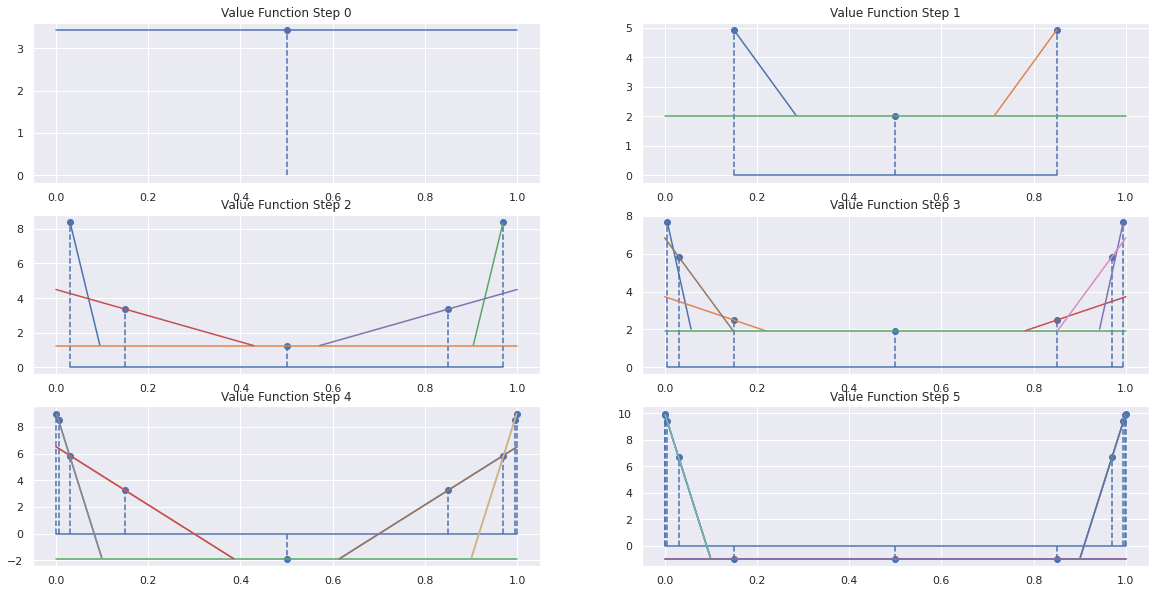

In [13]:
display(policies, ncols=2)

## Run the agent in the environment

In [14]:
# define environment
# you can change the number of steps
env = TigerEnv(max_num_steps=4)

# solve environment
policies = point_based_value_backup(env=env, gamma=0.9)
print(policies[0])

# do a few experiments
scores = []
num_experiments = 10

for i in range(num_experiments):
    # reset environment
    env.reset()
    
    # initial belief state
    b = np.array([0.5, 0.5])
    
    # score variable & buffer actions
    score = 0
    acts, obs = [], []
    
    for step in count():
        # interact with the environment
        b = get_closest_belief(policies[step]["policy"], b)
        a = policies[step]["policy"][tuple(b)]
        o, r, done, _ = env.step(a)
        
        # update score, acts & obs
        score += r
        acts.append(a)
        obs.append(o)
        
        # break if environment completed
        if done:
            acts = [env.action_mapping[a] for a in acts]
            obs = [env.obs_mapping[o] for o in obs]
            
            print("Episode %d, Score: %.2f" % (i, score))
            print("\t* Actions:", acts)
            print("\t* Obs:", obs)
            print("\n")
            break
        
        # update belief
        b = update_belief(b=b, a=a, o=o, env=env)
    
    # save score
    scores.append(score)
    
# report mean score
print("=================")
print("Avg score: %.2f" % (np.mean(scores), ))

{'policy': {(0.5, 0.5): <Actions.LISTEN: 0>}, 'V': [array([1.24209125, 1.24209125])], 'scores': [1.24209125]}
Episode 0, Score: 7.00
	* Actions: ['Listen', 'Listen', 'Listen', 'Right']
	* Obs: ['Tiger Left', 'Tiger Left', 'Tiger Left', 'Tiger Right']


Episode 1, Score: 7.00
	* Actions: ['Listen', 'Listen', 'Listen', 'Left']
	* Obs: ['Tiger Right', 'Tiger Right', 'Tiger Right', 'Tiger Right']


Episode 2, Score: 7.00
	* Actions: ['Listen', 'Listen', 'Listen', 'Left']
	* Obs: ['Tiger Right', 'Tiger Right', 'Tiger Right', 'Tiger Right']


Episode 3, Score: 7.00
	* Actions: ['Listen', 'Listen', 'Listen', 'Right']
	* Obs: ['Tiger Left', 'Tiger Left', 'Tiger Left', 'Tiger Right']


Episode 4, Score: 7.00
	* Actions: ['Listen', 'Listen', 'Listen', 'Left']
	* Obs: ['Tiger Right', 'Tiger Right', 'Tiger Right', 'Tiger Right']


Episode 5, Score: -4.00
	* Actions: ['Listen', 'Listen', 'Listen', 'Listen']
	* Obs: ['Tiger Right', 'Tiger Left', 'Tiger Left', 'Tiger Left']


Episode 6, Score: -4.00
